# Capse.jl chains
In this notebook we will show how to use the Capse.jl emulator in combination with Turing.jl, performing a ACTPolLite analysis. In particolar, we are gonna show:

- How to compute the Maximum A Posteriori (MAP), using the L-BFGS method provided by Optim.jl
- How to use Pathfinder.jl to obtain a quick posterior estimate and initialize chains
- How to use NUTS and MicroCanonical Hamiltonian MonteCarlo as sampling algorithms

Let us start initializing the Julia environment. This will download and install the precise version of the required packages.

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.resolve()

  Activating project at `~/Desktop/papers/capse_paper/standard_emulator`
Precompiling project...
  ✓ Plots
  ✓ Plots → FileIOExt
  ✓ Plots → UnitfulExt
  ✓ StatsPlots
  4 dependencies successfully precompiled in 57 seconds. 381 already precompiled.
  No Changes to `~/Desktop/papers/capse_paper/standard_emulator/Project.toml`
  No Changes to `~/Desktop/papers/capse_paper/standard_emulator/Manifest.toml`


In [2]:
using Statistics
using SimpleChains
using NPZ
using Turing
using Optim
using Pathfinder
using StatsPlots
using Capse
using BenchmarkTools
using LinearAlgebra
using NPZ
using Transducers
using ACTPolLite
import MCMCChains: compute_duration
using MicroCanonicalHMC
using MCMCDiagnosticTools
using DataFrames
include("utils.jl")

[ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


extract_single (generic function with 1 method)

Here we initialize the neural network we use for the emulator.
Do not modify this cell!

In [3]:
mlpd = SimpleChain(
  static(6),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(tanh, 64),
  TurboDense(identity, 4999)
);

After creating the neural network, we initialize our emulators.

In [4]:
weights_folder = "../data/weights/weights_cosmopowerspace_10000/"
ℓ = npzread(weights_folder*"l.npy")

weights_TT = npzread(weights_folder*"weights_TT_lcdm.npy")
trained_emu_TT = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_TT)
CℓTT_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_TT, ℓgrid = ℓ,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓTT_lcdm.npy"));

In [5]:
weights_EE = npzread(weights_folder*"weights_EE_lcdm.npy")
trained_emu_EE = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_EE)
CℓEE_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_EE, ℓgrid = ℓ,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓEE_lcdm.npy"));

In [6]:
weights_TE = npzread(weights_folder*"weights_TE_lcdm.npy")
trained_emu_TE = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_TE)
CℓTE_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_TE, ℓgrid = ℓ,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓTE_lcdm.npy"));

In [7]:
weights_PP = npzread(weights_folder*"weights_PP_lcdm.npy")
trained_emu_PP = Capse.SimpleChainsEmulator(Architecture= mlpd, Weights = weights_PP)
CℓPP_emu = Capse.CℓEmulator(TrainedEmulator = trained_emu_PP, ℓgrid = ℓ,
                             InMinMax = npzread(weights_folder*"inMinMax_lcdm.npy"),
                             OutMinMax = npzread(weights_folder*"outMinMaxCℓPP_lcdm.npy"));

## ACTPolLite & Turing

Here we are going tyo create some functions to analyze ACTPol data.
The first function, given a list of arguments, retrieves the binned $C_\ell$'s 

In [8]:
ls = 2:5000
fac=ls.*(ls.+1)./(2*π)

function call_emu_actpol(θ, Emu_TT, Emu_TE, Emu_EE, fac)
    return Capse.get_Cℓ(θ, Emu_TT)./fac, Capse.get_Cℓ(θ, Emu_TE)./fac, Capse.get_Cℓ(θ, Emu_EE)./fac
end

call_emu_actpol (generic function with 1 method)

This other function is a closure, defining a more manageable version of the same function (in this way we don't have to pass some fixed arguments)

In [9]:
theory_actpol(θ) = call_emu_actpol(θ, CℓTT_emu, CℓTE_emu, CℓEE_emu, fac)

theory_actpol (generic function with 1 method)

In [10]:
x = rand(6)
@benchmark theory_actpol($x)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  119.938 μs …   2.364 ms  ┊ GC (min … max): 0.00% … 88.56%
 Time  (median):     132.707 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   141.195 μs ± 102.022 μs  ┊ GC (mean ± σ):  3.30% ±  4.32%

         ▁▂ ██▁▁▂                                                
  ▁▁▁▁▂▂▃█████████▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  120 μs           Histogram: frequency by time          180 μs <

 Memory estimate: 353.84 KiB, allocs estimate: 46.

Since the Covariance matrix we are gonna use does not depend on the model parameters, we can define the following quantities

$\Gamma = \mathrm{sqrt}(\Lambda)$

$i\Gamma=\mathrm{inv}(\Gamma)$

$D = i\Gamma \cdot d$

We can now sample a MvNormal with an easier covariance matrix

$D \sim \mathrm{MvNormal}(i\Gamma\cdot t(\theta), I)$

The advantage of this reparametrization is that we compute the inverse of a matrix just once and not at every step of the MCMC, without resoirting to any approximation: the two likelihood defined are mathematically equivalent.

In [11]:
Γ = sqrt(ACTPolLite.cov_ACT)
iΓ = inv(Γ)
D = iΓ * ACTPolLite.data;

Although this is a bit different from the way we are used to code likelihoods in cosmology, it is easy to explain how to use a Probabilistic Programming Language (PPL) such as Turing.

When we use the "$\sim$" symbol, we are saying that the left-hand-side is sampled from the distribution on the right-hand-side

In [12]:
@model function CMB_ACTPol(D, iΓ, WF)
    ln10As ~ Uniform(0.25, 0.35)
    ns     ~ Uniform(0.88, 1.06)
    h0     ~ Uniform(0.60, 0.80)
    ωb     ~ Uniform(0.1985, 0.25)
    ωc     ~ Uniform(0.08, 0.20)
    τ      ~ Normal(0.065, 0.015)
    yₚ     ~ Uniform(0.9, 1.1)

    θ = [10*ln10As, ns, 100*h0, ωb/10, ωc, τ]
    tt, te, ee = theory_actpol(θ)

    te .*= yₚ
    ee .*= yₚ^2
    
    X_model = iΓ * ACTPolLite.compone_window_Cℓ(tt, te, ee, WF)
    
    D ~ MvNormal(X_model, I)
end

CMB_ACTPol_model = CMB_ACTPol(D, iΓ, ACTPolLite.WF)

DynamicPPL.Model{typeof(CMB_ACTPol), (:D, :iΓ, :WF), (), (), Tuple{Vector{Float64}, Matrix{Float64}, ACTPolLite.WindowFunction}, Tuple{}, DynamicPPL.DefaultContext}(CMB_ACTPol, (D = [14.205163574582478, 15.30450143336489, 14.56564669095626, 16.763718445804457, 17.05254865673962, 16.684724229109758, 17.452344541673025, 16.928490212520057, 14.640608110250994, 17.531181362696884  …  1.829926717495442, 2.93882261277649, 0.9932290154920781, -0.5676077518248538, -0.8833722892840291, 1.3437306697752764, -0.9295339091838362, -0.3300207789293402, -2.047112217043857, 1.9987987251210189], iΓ = [326.14982693005754 31.336951058849 … -1.7281563505028354 0.1899904418975723; 31.336951058849003 484.21856239540347 … -1.7485633339100106 -0.8733716389720488; … ; -1.7281563505028361 -1.7485633339100104 … 1.2505242271575176e6 31639.628206689795; 0.1899904418975724 -0.8733716389720484 … 31639.628206689795 1.1463485606934512e6], WF = ACTPolLite.WindowFunction([3.2265368598882327e-7 4.3049057544775417e-7 … -9.

Let us perform the MAP computation. Turing has been interfaced with Optim, which provides some powerful minimization methods such as L-BFGS.

In [13]:
bestfit_ACTPol = optimize(CMB_ACTPol_model, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))
@benchmark optimize(CMB_ACTPol_model, MAP(), Optim.Options(iterations=100000, allow_f_increases=true))

┌ Warning: #= /home/marcobonici/.julia/packages/ACTPolLite/sD4eR/src/ACTPolLite.jl:75 =#:
│ `LoopVectorization.check_args` on your inputs failed; running fallback `@inbounds @fastmath` loop instead.
│ Use `warn_check_args=false`, e.g. `@turbo warn_check_args=false ...`, to disable this warning.
└ @ ACTPolLite ~/.julia/packages/LoopVectorization/91gMc/src/condense_loopset.jl:1148


BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  387.751 ms … 837.221 ms  ┊ GC (min … max): 0.97% … 1.77%
 Time  (median):     542.136 ms               ┊ GC (median):    1.39%
 Time  (mean ± σ):   562.722 ms ± 127.994 ms  ┊ GC (mean ± σ):  1.51% ± 0.27%

  █         ██ █  █        █    █  █ █                        █  
  █▁▁▁▁▁▁▁▁▁██▁█▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  388 ms           Histogram: frequency by time          837 ms <

 Memory estimate: 245.60 MiB, allocs estimate: 14835.

The minimization takes less than half a second!

We are going to run 6 parallel chains, with 500 adaptation steps and 5'000 steps (note that Turing will not retrieve the burn-in steps)

In [14]:
nsteps = 5000
nadapts = 500
nchains = 6

6

Before starting chains, let us use Pathfinder. This will deliver an approximation to the posterior

In [15]:
result_multi = multipathfinder(CMB_ACTPol_model, 10000; nruns=8, executor=Transducers.PreferParallel())

┌ Warning: 1 (0.5%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.6%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (1.0%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 3 (1.2%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.5%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.4%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~

Multi-path Pathfinder result
  runs: 8
  draws: 10000
  Pareto shape diagnostic: 0.8 (bad)

In [18]:
@time multipathfinder(CMB_ACTPol_model, 10000; nruns=8, executor=Transducers.PreferParallel())

┌ Warning: 2 (1.1%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 1 (0.5%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (1.0%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.9%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.8%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~/.julia/packages/Pathfinder/1B4yO/src/singlepath.jl:212
┌ Warning: 2 (0.9%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder ~

 14.734311 seconds (4.85 M allocations: 20.047 GiB, 2.82% gc time)


Multi-path Pathfinder result
  runs: 8
  draws: 10000
  Pareto shape diagnostic: 0.93 (bad)

In [17]:
result_multi.draws_transformed

Chains MCMC chain (10000×7×1 Array{Float64, 3}):

Iterations        = 1:1:10000
Number of chains  = 1
Samples per chain = 10000
parameters        = ln10As, ns, h0, ωb, ωc, τ, yₚ

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat 
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64 

      ln10As    0.3043    0.0029     0.0000    0.0000   10093.0622    1.0001
          ns    1.0145    0.0154     0.0002    0.0002   10075.5885    0.9999
          h0    0.6833    0.0148     0.0001    0.0002    9601.4255    0.9999
          ωb    0.2148    0.0030     0.0000    0.0000    9926.1644    0.9999
          ωc    0.1166    0.0036     0.0000    0.0000    9680.4598    0.9999
           τ    0.0633    0.0136     0.0001    0.0001    9916.1512    1.0001
          yₚ    1.0004    0.0046     0.0000    0.0000   10183.1358    0.9999

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float6

In [29]:
chain_actpol_PF = combine_chains(result_multi.draws_transformed)
npzwrite("chains_ACT_PF.npy", chain_actpol_PF)

Pathfinder is incredibly fast: it performed the analysis in as few as 15 seconds. However, it is an approximate method. Although it might not always used to give a faithful approximation of the posteriori, it is very useful in starting the chains as close as possible to the typical set.

Here we are gonna use some Pathfinder draws to initialize our chains.

In [19]:
init_params = collect.(eachrow(result_multi.draws_transformed.value[1:nchains, :, 1]));

Let us now start the NUTS chains.

In [20]:
chains_actpol_nuts = sample(CMB_ACTPol_model, NUTS(nadapts, 0.65), MCMCThreads(), nsteps, nchains; init_params)

┌ Info: Found initial step size
└   ϵ = 0.00625
┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.00625
┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.00625
Sampling (6 threads): 100%|█████████████████████████████| Time: 0:22:30


Chains MCMC chain (5000×19×6 Array{Float64, 3}):

Iterations        = 501:1:5500
Number of chains  = 6
Samples per chain = 5000
Wall duration     = 2671.81 seconds
Compute duration  = 11964.1 seconds
parameters        = ln10As, ns, h0, ωb, ωc, τ, yₚ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

      ln10As    0.3048    0.0030     0.0000    0.0000   15794.6770    1.0003   ⋯
          ns    1.0104    0.0154     0.0001    0.0001   17206.7103    1.0000   ⋯
          h0    0.6830    0.0151     0.0001    0.0001   14305.2264    1.0001   ⋯
          ωb    0.2155    0.0031     0.0000    0.0000   22887.1189    1.0000   ⋯
          ωc    0.1168    0.0037     0.

Let us plot our chains. As we can see, the samples looks almost uncorrelated, which is consistent with our estimate of the correlation length, which is between 2-3 for cosmological parameters.

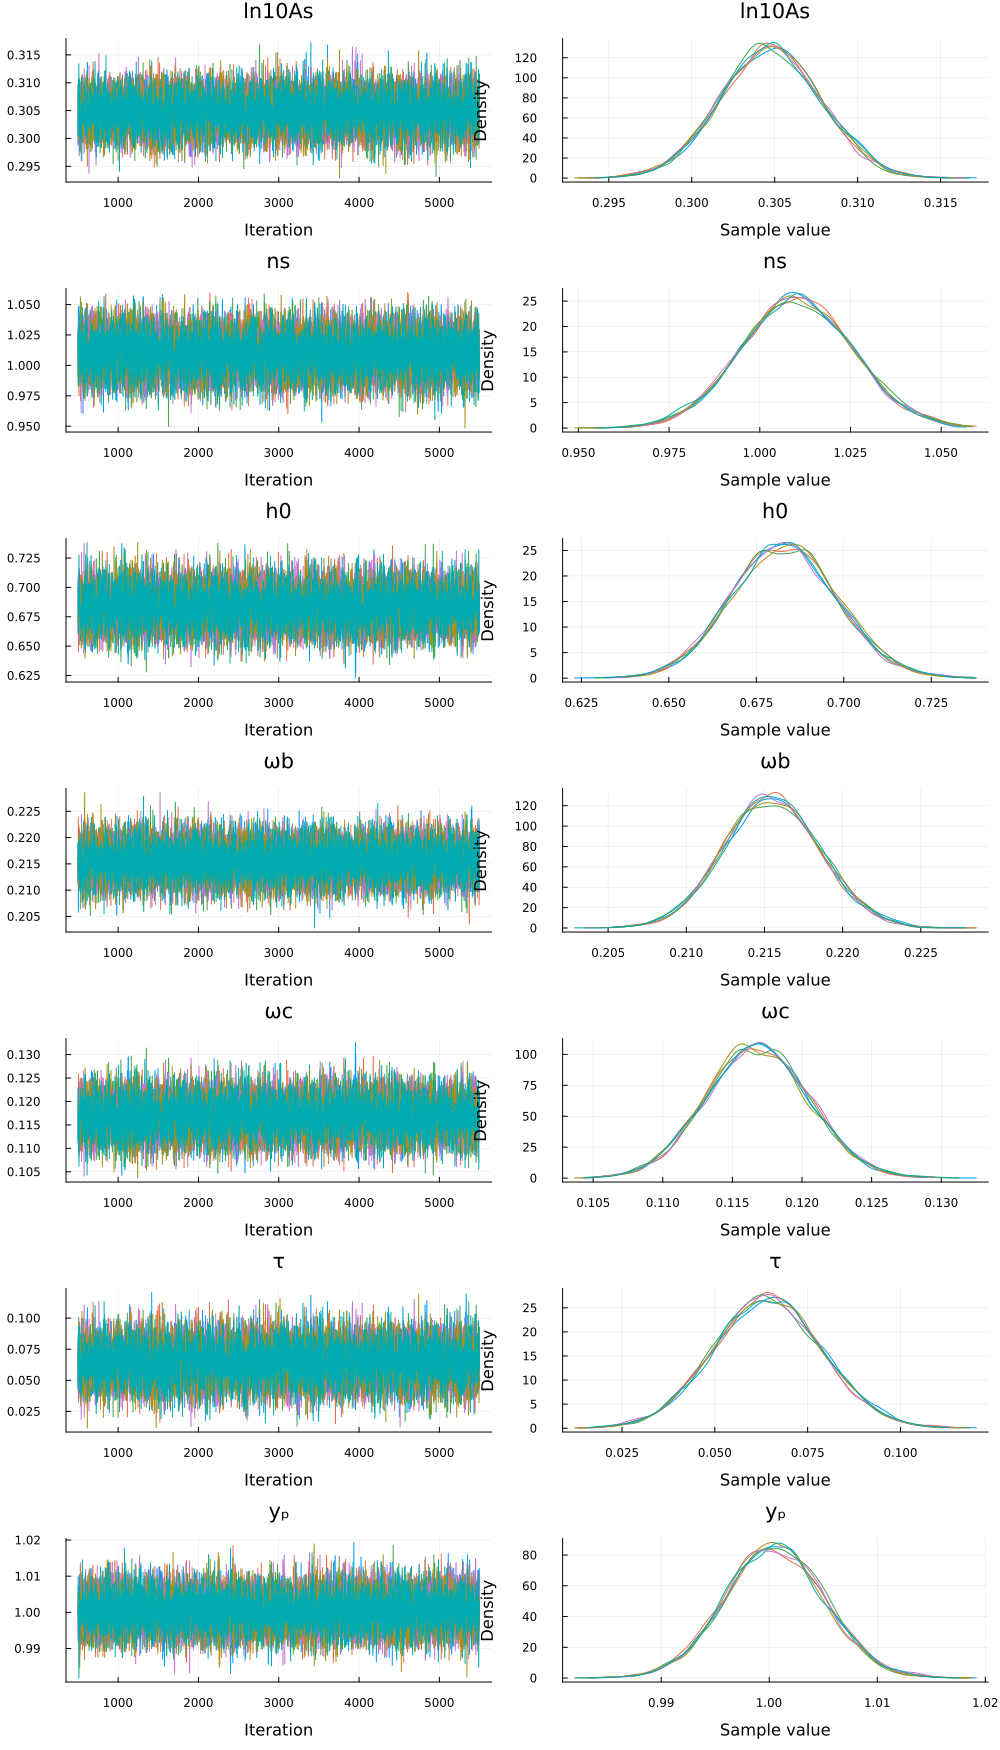

In [21]:
p = StatsPlots.plot(chains_actpol_nuts)
StatsPlots.savefig("traceplots_ACT.png")
p

In [22]:
chain_act = combine_chains(chains_actpol_nuts)
npzwrite("chains_ACT_NUTS.npy", chain_act)

An interesting quantity we will compare with the MCHMC run is the ESS per second

In [23]:
CPU_s_ACTPol_NUTS = compute_duration(chains_actpol_nuts)
ACTPol_NUTS_ESS = mean(MCMCDiagnosticTools.ess_rhat(chains_actpol_nuts)[[:ln10As, :ns, :h0, :ωb,:ωc, :τ, :yₚ],:ess])
ACTPol_NUTS_ESS_s = ACTPol_NUTS_ESS/CPU_s_ACTPol_NUTS

1.4963681320926843

An ESS/s of 1.6 means that we can reach the (heuristic) threshold of 400 ESS in around 4 minutes and, taking advantage of the multiple processor, our analysis can be performed in around 1 minute.

## The MicroCanonical Hamiltonian MonteCarlo sampler
Here we will use the Julia implementation of the MCHMC sampler.
We will use 20'000 adaptation steps (that will be discarded) and 200'000 steps.

In [24]:
d = 7
target = TuringTarget(CMB_ACTPol_model)
nadapts = 20_000
nsteps = 200_000
spl = MCHMC(nadapts, 0.001; init_eps=0.05, L=sqrt(d),# sigma=ones(d),
            adaptive=true)
@time actpol_mchmc = Sample(spl, target, nsteps;
                       progress=true,
                       dialog=true, file_name="chain_1",
                       initial_x=bestfit_ACTPol.values.array)

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:16

Burn in step: 4000
eps --->0.006181511804658203


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:57

Burn in step: 8000
eps --->0.04760493267142703


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:38

Burn in step: 12000
eps --->0.05275507501443417


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.08175909952446245


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:35

Burn in step: 20000
eps --->0.08266755422459976


[ Info: eps: 0.08266755422459976
[ Info: L: 2.6457513110645907
[ Info: nu: 0.09597965749057638
[ Info: sigma: [0.19696612791923773, 0.5455455939745602, 0.46774123140453433, 0.37338458925490026, 0.3674152246243793, 0.01838934879065154, 0.10016768245775907]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:42

1041.842088 seconds (82.14 M allocations: 631.071 GiB, 2.23% gc time, 0.34% compilation time: <1% of which was recompilation)


200000-element Vector{Any}:
 [0.30621715449371995, 1.0219755834487747, 0.68263835858857, 0.21341538827632142, 0.11631447795341454, 0.06966346444643608, 1.0004530300241457, 0.08266755422459976, -0.04072821348012212, -389.3752208141797]
 [0.3060855259132938, 1.0212305244265907, 0.6840182493276781, 0.21341162842197497, 0.11628386155097523, 0.0696451054563515, 1.0005476427663715, 0.08296019676086189, -0.05830446624435126, -388.35219288124733]
 [0.3058571897249855, 1.0206900237473182, 0.6851698456461811, 0.21341578405001507, 0.11632197312875539, 0.06992132457249317, 1.0006920759972582, 0.08346675559712714, 0.008953887748134548, -387.5980399810018]
 [0.30557377766654625, 1.020076070133109, 0.6858808414695536, 0.21345964589737196, 0.11623076540704352, 0.0703283234579708, 1.0008112303440282, 0.08399149421949029, 0.01869564906303367, -387.09128372507104]
 [0.3053051209737681, 1.0193315098460685, 0.6862056596162586, 0.2135449617912236, 0.1160351962350805, 0.07077486257229701, 1.0009120544194994,

In [25]:
n_parallel_mchmc = 8
chains = Vector{Any}(undef, n_parallel_mchmc)
vec_ess = zeros(n_parallel_mchmc)

nadapts = 20_000
nsteps = 200_000
start_mchmc = time()

@time for i in 1:n_parallel_mchmc
    chains[i] = Sample(MCHMC(nadapts, 0.001; init_eps=0.05, L=sqrt(d), adaptive=true), target, nsteps;
                       progress=true,
                       dialog=true, file_name="chain_1",
                       initial_x=bestfit_ACTPol.values.array)
    vec_ess[i] = mean(Summarize(chains[i])[1][1:7])
end

end_mchmc = time()
time_mchmc_parallel_ACTPol = end_mchmc - start_mchmc

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:14

Burn in step: 4000
eps --->0.004645142307147579


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:55

Burn in step: 8000
eps --->0.15757788094534533


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:37

Burn in step: 12000
eps --->0.1424441991404979


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:18

Burn in step: 16000
eps --->0.14247270418246671


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:32

Burn in step: 20000
eps --->0.18097782466471768


[ Info: eps: 0.18097782466471768
[ Info: L: 2.6457513110645907
[ Info: nu: 0.1447194906665041
[ Info: sigma: [0.12092279984477865, 0.5475156875862977, 0.33003964434580835, 0.3021895254932947, 0.16332803297684528, 0.014162073202166512, 0.12429344021886692]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:20[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:13

Burn in step: 4000
eps --->0.003823357964651445


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:55

Burn in step: 8000
eps --->0.10173703524467533


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:36

Burn in step: 12000
eps --->0.12363972498287228


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:18

Burn in step: 16000
eps --->0.12933458934776657


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:31

Burn in step: 20000
eps --->0.14892515647641064


[ Info: eps: 0.14892515647641064
[ Info: L: 2.6457513110645907
[ Info: nu: 0.13047071148676465
[ Info: sigma: [0.16845883063536696, 0.5364917507617929, 0.384336693982975, 0.9204355823394568, 0.16219296753818416, 0.017878553283907233, 0.08431004130373602]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:26[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:14

Burn in step: 4000
eps --->0.004937613484608956


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:55

Burn in step: 8000
eps --->0.11274531518307007


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:37

Burn in step: 12000
eps --->0.1758158489776687


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.14159456018050925


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:33

Burn in step: 20000
eps --->0.1686590087076937


[ Info: eps: 0.1686590087076937
[ Info: L: 2.6457513110645907
[ Info: nu: 0.13937529493425402
[ Info: sigma: [0.13947109695749818, 0.6086252046772764, 0.30798664922425517, 0.3442024576349128, 0.149853452812309, 0.01936906461745127, 0.15217677285742082]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:22[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:18

Burn in step: 4000
eps --->0.0043376416477986


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:56

Burn in step: 8000
eps --->0.19274754116562104


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:37

Burn in step: 12000
eps --->0.16254832341674125


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.1864885707769216


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:33

Burn in step: 20000
eps --->0.20919661594467195


[ Info: eps: 0.20919661594467195
[ Info: L: 2.6457513110645907
[ Info: nu: 0.1564460500616851
[ Info: sigma: [0.12538161257878347, 0.47788560755374276, 0.3051937505475806, 0.2732719162805608, 0.1486742622366271, 0.01497543102054534, 0.09459791078924722]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:24[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:16

Burn in step: 4000
eps --->0.004573954985414945


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:57

Burn in step: 8000
eps --->0.1131250896058413


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:38

Burn in step: 12000
eps --->0.12962013256422028


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.12099130103390787


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:34

Burn in step: 20000
eps --->0.14058320992962473


[ Info: eps: 0.14058320992962473
[ Info: L: 2.6457513110645907
[ Info: nu: 0.12656061763258122
[ Info: sigma: [0.16668150033464513, 0.5320743129911834, 0.35999493159522367, 0.304313455647779, 0.16702895737958684, 0.020091117155367367, 0.09699165961574753]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:27[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:15

Burn in step: 4000
eps --->0.00516136241490353


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:56

Burn in step: 8000
eps --->0.062290490010913455


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:38

Burn in step: 12000
eps --->0.0662163497678478


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.08640025243880234


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:33

Burn in step: 20000
eps --->0.09856374587541276


[ Info: eps: 0.09856374587541276
[ Info: L: 2.6457513110645907
[ Info: nu: 0.10512107854758278
[ Info: sigma: [0.16139758420858355, 1.3850542573450373, 0.5162717331659227, 0.43222006467813406, 0.24359478332386172, 0.015401601255167173, 0.24173562696791398]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:26[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:13

Burn in step: 4000
eps --->0.005560389241316762


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:55

Burn in step: 8000
eps --->0.05462019016549364


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:37

Burn in step: 12000
eps --->0.0989540365504626


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:19

Burn in step: 16000
eps --->0.12090586322326917


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:32

Burn in step: 20000
eps --->0.1056758911411213


[ Info: eps: 0.1056758911411213
[ Info: L: 2.6457513110645907
[ Info: nu: 0.10899595941571802
[ Info: sigma: [0.21435685611352354, 0.45512447645296056, 0.41705600501197637, 0.2817147229266759, 0.18332460394270847, 0.027166638964399276, 0.16505491260274366]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:15:23[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
MCHMC (tuning):  20%|███████                            |  ETA: 0:01:13

Burn in step: 4000
eps --->0.004525831791203087


MCHMC (tuning):  40%|██████████████                     |  ETA: 0:00:55

Burn in step: 8000
eps --->0.026395388733536546


MCHMC (tuning):  60%|█████████████████████              |  ETA: 0:00:36

Burn in step: 12000
eps --->0.025183315796546365


MCHMC (tuning):  80%|████████████████████████████       |  ETA: 0:00:18

Burn in step: 16000
eps --->0.04003201792523453


MCHMC (tuning): 100%|███████████████████████████████████|  ETA: 0:00:00

Burn in step: 20000
eps --->0.036488904134220915


2mMCHMC (tuning): 100%|███████████████████████████████████| Time: 0:01:29[ Info: eps: 0.036488904134220915
[ Info: L: 2.6457513110645907
[ Info: nu: 0.06320821848969736
[ Info: sigma: [0.13209082663988497, 0.5518251230023438, 0.7726220835654195, 0.3190714251181435, 0.6054063920290459, 0.014528309123486256, 0.19895464313973338]
[ Info: adaptive: true
2mMCHMC: 100%|████████████████████████████████████████████| Time: 0:14:24

8092.076499 seconds (608.49 M allocations: 4.974 TiB, 2.33% gc time)


8092.110419034958

Let us compute the ESS per second of the parallel MCHMC run.

In [26]:
ACTPol_MCHMC_parallel_ESS_s = sum(vec_ess)/time_mchmc_parallel_ACTPol

4.174276747414833

This is higher by a factor of 2.5 than the NUTS ESS/s!

In [27]:
_chains = zeros(nsteps, n_parallel_mchmc, 7)
for i in 1:n_parallel_mchmc
    _chains[:,i,:] = mapreduce(permutedims, vcat, chains[i])[:,1:7]
end

In [28]:
actpol_mchmc = mapreduce(permutedims, vcat, actpol_mchmc)
E = actpol_mchmc[:, end-1]
std(E).^2/d

0.001032843478517538

In [29]:
x = [mapreduce(permutedims, vcat, chains[i]) for i in 1:n_parallel_mchmc]

actpol_mchmc_multi_chains = zeros(nsteps*n_parallel_mchmc, 7)
for i in 1:7
    actpol_mchmc_multi_chains[:,i] = extract_single(x, i, n_parallel_mchmc)
end

In [30]:
npzwrite("chains_ACT_MCHMC.npy", actpol_mchmc)
npzwrite("chains_ACT_MCHMC_multi.npy", actpol_mchmc_multi_chains)